# Assignment 4 - Cosine Distance and Movie Tastes

Khaled Alhosani (kah579) Myunggun Seo (ms9144)

---

## LogCounter.py
timer and counter in logarithmic unit

In [1]:
import math
from datetime import datetime
import traceback

class LogCounter():
	"""counts in exponential unit"""
	def __init__(self, base=10):
		if base == 10:
			self.log = math.log10
		elif base == 2:
			self.log = math.log2
		elif base == 'e':
			self.log = math.log
		else:
			self.log = lambda x: math.log(x, base)
		self.count = 0
		self.logcount = 0
		self.startingTime = datetime.now()

	def __enter__(self):
		print("Started at {}".format(self.startingTime))
		return self

	def __exit__(self, exc_type, exc_value, exc_traceback):
		if exc_value == None:
			print("Loop Successful. Count: {}".format(self.count))
		else:
			print("Loop failed.")
			traceback.print_exception(exc_type, exc_value, exc_traceback)
		print("Ended at {} Total Time {}".format(datetime.now(), datetime.now() - self.startingTime))
		return True

	def increment(self, msg=""):
		self.count += 1
		if self.log(self.count) >= self.logcount:
			self.logcount += 1
			print("Time elapsed: {2}  Count: {0}  {1}".format(self.count, msg, datetime.now() - self.startingTime))




## functions.py
helper functions

In [2]:
import string
import math
import itertools
from functools import reduce

def getWords(line, delimiter=','):
	words = line.strip().lower().split(delimiter)
	return list( map(lambda w: w.strip(string.punctuation), words) )

def createUserDict(filename="ratings.csv"):
	'''creates dict of K-V shape (uid, (mid, r)) and sorted list of all MIDs'''
	userDict = {}
	midSet = set([])

	with open(filename, "r") as infile:
		lst = list(map(getWords, infile.read().splitlines()))
		lst = list(map(lambda t: (int(t[0]), (int(t[1]), float(t[2]))), lst)) #(uid, (mid, r))

	for rating in lst:
		(uid, (mid, r)) = rating
		midSet.add(mid)
		user = userDict.get(uid, {})
		user[mid] = r
		userDict[uid] = user
	return userDict, sorted(midSet)


def cosd(u, v):
	'''cosine distance function
	u, v = user entries from userDict
	m = length of user/random vector'''
	midSet = set(u.keys()) & set(v.keys())
	dotproduct = 0
	for mid in midSet:
		dotproduct += u.get(mid, None) * v.get(mid, None)
	square = lambda x: x**2
	add = lambda x, y: x + y
	mag = reduce(add, map(square, u.values())) * reduce(add, map(square, v.values())) #|u|*|v|
	mag **= 1/2
	assert mag != 0
	return math.acos(dotproduct/mag)

def choose(lst, r):
    #returns all "choose r" combinations as a set
    return set(map(lambda x: tuple(sorted(x)), itertools.combinations(lst, r)))

## preAnalysis.py
plots histograms, calculates r,b values

In [3]:
# preAnalysis.py

import matplotlib.pyplot as plt
%matplotlib inline
import math
from random import gauss
# from functions import cosd, createUserDict

def cosDistanceHistogram(userDict):
	'''computes cosine distance for given sample of users and draws histogram'''
	ijcosds = []
	for i, u in userDict.items():
		for j, v in userDict.items():
			if i < j:
				ijcosds.append(((i,j), cosd(u,v)))

	plt.subplot()
	plt.hist(list(map(lambda x:x[1], ijcosds)), 'auto')
	plt.show()

	return ijcosds

def rbCandidates(p=.98, s=.43, rrange=range(2, 20), brange=range(1, 20)):
	# Finds (b,r) parameters required for documents of 
	# JS similarity s to be in candidate groups with probability p
	q = 1 - p
	res = []

	for b in brange:
		for r in rrange:
			if (1 - s**r < q**(1/b)):
				res.append((r,b))
	l = len(res)
	print(l, "candidates for r,b values")
	if l < 250:
		print(res)
	return res

def rbAnalysis(rb=[(4,32), (8,16), (8,32), (4,8), (4,4), (2,8), (8,12), (12,8), (2,4)], S=.43):
	# for given (b,r) parameters, finds at which point s in [0,1] the slope is maximum.
	# also finds probability of document pairs that have JS=S is in candidate pairs
	# ordered r first, b second
	
	fx = lambda s,r,b: 1-(1-s**r)**b #the probability function
	tx = lambda r,b: (1/b)**(1/r) #approximation of threshold

	for (r,b) in rb:
		max_slope_threshold = (0, -1) # (s, f'(s))
		falsePositiveRate = 0
		falseNegativeRate = 0

		intervals = 1000
		intervalSize = 1/intervals
		for s in range(0,intervals):
			s = s/intervals
			fpx = r*b*(1-s**r)**(b-1)*s**(r-1)
			if fpx > max_slope_threshold[1]:
				max_slope_threshold = (s, fpx)
			if s < S:
				falsePositiveRate += intervalSize * fx(s,r,b) / S
			else:
				falseNegativeRate += intervalSize * (1-fx(s,r,b)) / (1-S)

		print("r={} b={}  \t|  threshold={} \t p({:.4f})={:.4f} \t false-pos={:.4f} \t false-neg={:.4f}"\
			.format(r, b, max_slope_threshold[0], S, fx(S, r, b), falsePositiveRate, falseNegativeRate))

def createRandomVectors(k, m, filename="randomVectors.csv"):
	'''creates k random vectors in m dimensions'''
	with open(filename, "w") as outfile:
		for i in range(k):
			for j in range(m):
				outfile.write("{:.8f} ".format(gauss(0,1)))
			outfile.write('\n')

def dot(userVector, vec, mids):
	'''userVector is a sparse vector (dictionary) of (mid,r) entries
	vec is a dense vector that has all m components(list of floats)'''
	product = 0
	for mid, r in userVector.items():
		try:
			i = mids.index(mid)
		except ValueError as e:
			print("mids length {} mid {}".format(len(mids), mid))
			raise e
		product += r * vec[i]
	return product

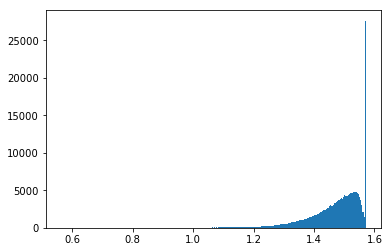

51 candidates for r,b values
[(1, 4), (1, 5), (1, 6), (2, 6), (1, 7), (2, 7), (1, 8), (2, 8), (1, 9), (2, 9), (3, 9), (1, 10), (2, 10), (3, 10), (1, 11), (2, 11), (3, 11), (1, 12), (2, 12), (3, 12), (1, 13), (2, 13), (3, 13), (4, 13), (1, 14), (2, 14), (3, 14), (4, 14), (1, 15), (2, 15), (3, 15), (4, 15), (1, 16), (2, 16), (3, 16), (4, 16), (1, 17), (2, 17), (3, 17), (4, 17), (5, 17), (1, 18), (2, 18), (3, 18), (4, 18), (5, 18), (1, 19), (2, 19), (3, 19), (4, 19), (5, 19)]
r=1 b=4  	|  threshold=0.0 	 p(0.7500)=0.9961 	 false-pos=0.7329 	 false-neg=0.0008
r=1 b=5  	|  threshold=0.0 	 p(0.7500)=0.9990 	 false-pos=0.7772 	 false-neg=0.0002
r=1 b=6  	|  threshold=0.0 	 p(0.7500)=0.9998 	 false-pos=0.8089 	 false-neg=0.0000
r=2 b=6  	|  threshold=0.302 	 p(0.7500)=0.9930 	 false-pos=0.5451 	 false-neg=0.0011
r=1 b=7  	|  threshold=0.0 	 p(0.7500)=0.9999 	 false-pos=0.8327 	 false-neg=0.0000
r=2 b=7  	|  threshold=0.277 	 p(0.7500)=0.9969 	 false-pos=0.5751 	 false-neg=0.0004
r=1 b=8  	|  t

In [4]:
userDict, midSet = createUserDict()
ijcosds = cosDistanceHistogram(userDict)

# s = 1-1.15/math.pi #p(placed in same bucket if cosd=1.15)
s = 0.75 # cosd = pi/4
rb = rbCandidates(p=.99, s=s, rrange=range(1, 10), brange=range(1, 20))
rbAnalysis(rb=rb, S=s)

# userDict, midSet = createUserDict()
# createRandomVectors(44, len(midSet))

## main.py
Use random vectors to hash users into buckets and find candidate pairs using banding technique.
Plot result

In [5]:
import math
from functools import reduce
import matplotlib.pyplot as plt


# open randomVectors and userDict
userDict, mids = createUserDict("ratings.csv")
with open("randomVectors.csv", "r") as infile:
	getNums = lambda line: list(map(float, line.strip().split()))
	randomVectors = list(map(getNums, infile.read().splitlines()))

# for each randomVector, userVectors were divided into two buckets. 
# union of set of pairs from two buckets are put into a row
# 'bands' has b number of bands and each band has r number of rows
r=3
b=9
bands = [[[] for j in range(r)] for i in range(b)]

with LogCounter(base=16) as lc:
	for i, vec in enumerate(randomVectors):
		if i >= r*b:
			break
		print("Computing dot products of randomVector #{} and userVectors".format(i))
		buckets = {'positive':[], 'negative':[]}
		for uid, user in userDict.items():
			lc.increment() #count number of userVectors * randomVectors
			sign = ('positive', 'negative')[dot(user, vec, mids) < 0] #gets sign of dot product
			buckets.get(sign).append(uid)
		for bucket in buckets.values():
			assert i//r < b, "band index i//r wrong"
			assert i%r < r, "row index i\%r wrong"
			bands[i//r][i%r] += list(choose(bucket, 2)) #put pairs into rows. (a,b) and (b,a) are treated the same


Started at 2018-02-25 21:02:53.809112
Computing dot products of randomVector #0 and userVectors
Time elapsed: 0:00:00.000342  Count: 1  
Time elapsed: 0:00:00.151169  Count: 16  
Time elapsed: 0:00:01.739255  Count: 256  
Computing dot products of randomVector #1 and userVectors
Computing dot products of randomVector #2 and userVectors
Computing dot products of randomVector #3 and userVectors
Computing dot products of randomVector #4 and userVectors
Computing dot products of randomVector #5 and userVectors
Computing dot products of randomVector #6 and userVectors
Time elapsed: 0:00:30.243793  Count: 4096  
Computing dot products of randomVector #7 and userVectors
Computing dot products of randomVector #8 and userVectors
Computing dot products of randomVector #9 and userVectors
Computing dot products of randomVector #10 and userVectors
Computing dot products of randomVector #11 and userVectors
Computing dot products of randomVector #12 and userVectors
Computing dot products of randomVec

In [6]:
# Find candidate pairs
with LogCounter() as lc: #used for timing
	#map each row to a set, reduce rows in each band using &, reduce bands using |
	AND = lambda s, t: s & t
	OR = lambda s, t: s | t
	candidatePairs = reduce(OR, map(lambda band: reduce(AND, map(set, band)), bands))
	print("length of candidate weekends", len(candidatePairs), len(candidatePairs)/(671*670/2))


s = 0.75
# Calculate distances of candidate pairs
candidateijCosds = []
candidateCosds = []
resultijCosds = []
resultCosds = []
keys = userDict.keys()
with LogCounter(base=16) as lc:
	for (i, j) in candidatePairs:
		lc.increment()
		assert i in keys
		assert j in keys
		d = cosd(userDict.get(i), userDict.get(j))
		candidateijCosds.append(((i,j),d))
		candidateCosds.append(d)
		if d < (1-s)*math.pi:
			resultijCosds.append(((i,j),d))
			resultCosds.append(d)



Started at 2018-02-25 21:05:02.500341
length of candidate weekends 172104 0.7656382765753943
Loop Successful. Count: 0
Ended at 2018-02-25 21:05:03.287173 Total Time 0:00:00.786838
Started at 2018-02-25 21:05:03.287584
Time elapsed: 0:00:00.000415  Count: 1  
Time elapsed: 0:00:00.003527  Count: 16  
Time elapsed: 0:00:00.044240  Count: 256  
Time elapsed: 0:00:00.558378  Count: 4096  
Time elapsed: 0:00:08.715641  Count: 65536  
Loop Successful. Count: 172104
Ended at 2018-02-25 21:05:26.303003 Total Time 0:00:23.015426


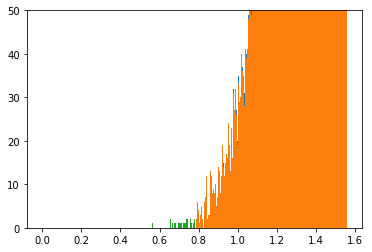

In [7]:
# Plot the cosine distances of 
# 1. all pairs
# 2. candidate pairs
# 3. the actual desirable pairs

plt.subplot()
plt.ylim(ymax=50)
binlist=[i/200 for i in range(312)]
plt.hist(list(map(lambda x:x[1],ijcosds)), bins=binlist)
plt.hist(candidateCosds, bins=binlist)
plt.hist(resultCosds, bins=binlist)
plt.show()


In [8]:
print("candidates:{} finalists:{} totalcontenders:{}".format(len(candidateCosds), len(resultCosds), len(ijcosds)))
for i, val in enumerate(sorted(ijcosds, key=lambda x:x[1])):
    if val[1] > (1-s)*math.pi:
        print("there shold actually be {} finalists".format(i))
        break

print(sorted(ijcosds, key=lambda x:x[1])[:i])

candidates:172104 finalists:23 totalcontenders:224785
there shold actually be 23 finalists
[((151, 369), 0.5636682799127491), ((279, 369), 0.6573413928802412), ((151, 400), 0.6581154741641095), ((82, 400), 0.6673917530945387), ((191, 513), 0.6797439897708369), ((151, 279), 0.6823767129373195), ((279, 400), 0.6973137018325868), ((50, 151), 0.7012126478857547), ((191, 449), 0.7087303243648356), ((369, 400), 0.7104094136954243), ((144, 375), 0.722752249754703), ((329, 459), 0.7278105382827054), ((108, 225), 0.7305217981190001), ((82, 191), 0.7354936163536018), ((144, 151), 0.736513061438354), ((317, 415), 0.7401664078548377), ((317, 556), 0.7404709799960699), ((145, 151), 0.7571474436827337), ((64, 657), 0.7572715451717987), ((279, 662), 0.7635117919364386), ((144, 400), 0.7706074822717078), ((145, 400), 0.7752634532851712), ((151, 535), 0.7768431229421576)]
